In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importar los datos

In [2]:
df = pd.read_json('rating_per_user.json', orient='records', lines=True)
df.head()

,ratingType,ratings,ratings_date,nof_reviews
0,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-27, 2021-01-13, 2021-01-13, 2021-02-0...",86
1,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-09, 2021-01-09, 2021-01-09, 2021-01-0...",85
2,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-01, 2021-01-01, 2021-01-20, 2021-01-2...",29
3,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-31, 2021-01-31, 2021-01-31, 2021-01-1...",28
4,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-22, 2021-01-22, 2021-01-22, 2021-01-2...",24


# Análisis exploratorio

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206396 entries, 0 to 206395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ratingType    206396 non-null  object
 1   ratings       206396 non-null  object
 2   ratings_date  206396 non-null  object
 3   nof_reviews   206396 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 6.3+ MB


In [4]:
df['ratingType'].value_counts()

SellerToBuyer    124552
BuyerToSeller     81844
Name: ratingType, dtype: int64

In [5]:
df['nof_reviews'].describe()

count    206396.000000
mean          1.038431
std           0.435590
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          86.000000
Name: nof_reviews, dtype: float64

In [6]:
# Creación de puntuación promedio y fechas máxima y mínima por registro
df['rating_avg'] = df['ratings'].apply(sum)/df['nof_reviews']
df['max_date'] =  df['ratings_date'].apply(max)
df['min_date'] =  df['ratings_date'].apply(min)

In [9]:
# Cambiar tipo de datos

df['max_date'] = pd.to_datetime(df['max_date'], format='%Y-%m-%d', errors='ignore')
df['min_date'] = pd.to_datetime(df['min_date'], format='%Y-%m-%d', errors='ignore')

In [11]:
# Creación variable diferencia fechas

df['date_dif'] = df['max_date'] - df['min_date']

In [12]:
df.head()

,ratingType,ratings,ratings_date,nof_reviews,rating_avg,max_date,min_date,date_dif
0,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-27, 2021-01-13, 2021-01-13, 2021-02-0...",86,5.0,2021-02-14,2021-01-07,38 days
1,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-09, 2021-01-09, 2021-01-09, 2021-01-0...",85,5.0,2021-02-14,2021-01-07,38 days
2,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-01, 2021-01-01, 2021-01-20, 2021-01-2...",29,5.0,2021-02-13,2021-01-01,43 days
3,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-31, 2021-01-31, 2021-01-31, 2021-01-1...",28,5.0,2021-02-12,2021-01-01,42 days
4,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-22, 2021-01-22, 2021-01-22, 2021-01-2...",24,5.0,2021-02-06,2021-01-17,20 days


In [34]:
df['rating_avg'].describe()

count    206396.000000
mean          4.904675
std           0.498043
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating_avg, dtype: float64

In [56]:
# Puntuación promedio de todo el dataframe

sum(df['rating_avg'])/len(df['rating_avg'])

4.904674859116564

In [59]:
# Puntuación promedio por tipo

df.groupby(by="ratingType").mean()

,nof_reviews,rating_avg
ratingType,,
BuyerToSeller,1.037730,4.880167
SellerToBuyer,1.038891,4.920779


In [14]:
# Fechas mínima y máxima de puntuaciones

print(' Fecha mínima:',min(df['min_date']),'\n','Fecha máxima:',max(df['max_date']))

 Fecha mínima: 2021-01-01 00:00:00 
 Fecha máxima: 2021-02-14 00:00:00


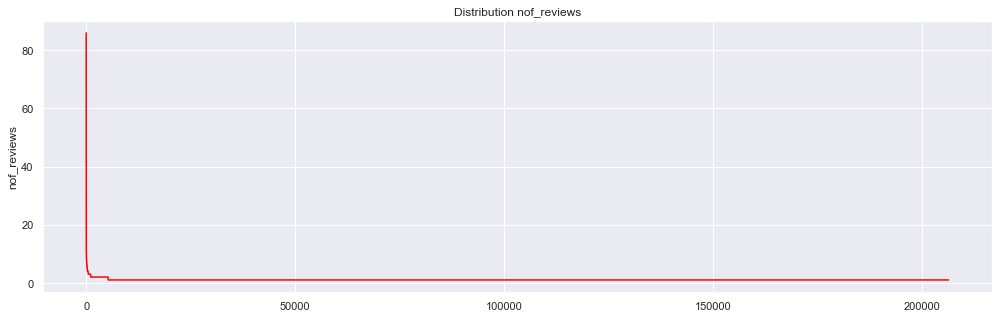

In [15]:
sns.set()
plt.figure(figsize=(17, 5))
plt.plot(df['nof_reviews'], color='red')
plt.title('Distribution nof_reviews')
plt.ylabel('nof_reviews')
plt.yscale('linear')
plt.show()

# Datos a nivel puntuación

In [28]:
df_2 = pd.melt(df, id_vars=['ratingType'], value_vars=['ratings', 'ratings_date', 'nof_reviews'])
df_2.head()

,ratingType,variable,value
0,SellerToBuyer,ratings,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
1,BuyerToSeller,ratings,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
2,BuyerToSeller,ratings,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
3,SellerToBuyer,ratings,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
4,BuyerToSeller,ratings,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."


In [27]:
len(df_2.iloc[0,2])

86

In [29]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619188 entries, 0 to 619187
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ratingType  619188 non-null  object
 1   variable    619188 non-null  object
 2   value       619188 non-null  object
dtypes: object(3)
memory usage: 14.2+ MB


In [16]:
help(pd.melt)

Help on function melt in module pandas.core.reshape.melt:

melt(frame: pandas.core.frame.DataFrame, id_vars=None, value_vars=None, var_name=None, value_name='value', col_level=None) -> pandas.core.frame.DataFrame
    Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
    
    This function is useful to massage a DataFrame into a format where one
    or more columns are identifier variables (`id_vars`), while all other
    columns, considered measured variables (`value_vars`), are "unpivoted" to
    the row axis, leaving just two non-identifier columns, 'variable' and
    'value'.
    
    Parameters
    ----------
    id_vars : tuple, list, or ndarray, optional
        Column(s) to use as identifier variables.
    value_vars : tuple, list, or ndarray, optional
        Column(s) to unpivot. If not specified, uses all columns that
        are not set as `id_vars`.
    var_name : scalar
        Name to use for the 'variable' column. If None it uses
        `

# Pruebas con dataframe pequeño

In [ ]:
# Exportar a csv
df.to_csv('ratings.csv',index=False)

In [ ]:
df_1 = pd.DataFrame(
[
    [[4,5,6], 7, 10],
    [[5,6,7], 8, 11],
    [[6,7,8], 9, 12]
], 
index=[1, 2, 3], 
columns=['a', 'b', 'c'])

In [ ]:
df_1.head()

In [ ]:
df_1['a'].sum()/df_1['a'].len()

In [ ]:
for i in range(0,len(df_1)):
    print (i)

In [ ]:
df_1['d']=df_1['a']

In [ ]:
for i in range(0,len(df_1)):
    df_1.iloc[i,3] = sum(df_1.iloc[i,0])/len(df_1.iloc[i,0])

In [ ]:
sum(df_1.iloc[0,0])/len(df_1.iloc[0,0])

In [ ]:
df_1.head()